In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ast
import time
import gc
import os
from itertools import product
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost

<h3>1. Load and Clean Data</h3>
<p>- Load data and unpack json sub-columns<br>
- We will exclude columns that only contain one value (not unique)<br>
- Fill in null values and set data type<br>
- Encode categorical features</p>

In [3]:
'''
DEFINE FUNCTION TO LOAD DATA
- load nested json as separate columns
- separate date elements into different columns
- load data with chunksize 1000 because data size is big
'''

def json_to_column(column_with_nested_json, nested_key):
    column = json.loads(column_with_nested_json)
    try:
        return column[nested_key]
    except:
        return float('NaN') 

def process_df(df):
    json_cols = {'totals':['hits', 'pageviews', 'bounces', 'newVisits', 'sessionQualityDim', 'transactionRevenue'],
                 'trafficSource':['campaign', 'source', 'medium', 'keyword'],
                 'device':['browser', 'operatingSystem', 'isMobile', 'deviceCategory'],
                 'geoNetwork':['continent', 'subContinent', 'country']}

    for key, val in json_cols.items():
        for item in val:
            col_name = '{}_{}'.format(key, item)
            df[col_name] = df[key].apply(lambda x: json_to_column(x, item))
    
    # filling in nan values
    df['totals_hits'].fillna(0, inplace=True)
    df['totals_pageviews'].fillna(0, inplace=True)
    df['totals_bounces'].fillna(0, inplace=True)
    df['totals_newVisits'].fillna(0, inplace=True)
    df['totals_sessionQualityDim'].fillna(0, inplace=True)
    df['totals_transactionRevenue'].fillna(0, inplace=True)

    # casting numerical columns to float/int
    df['totals_hits'] = df['totals_hits'].astype(int)
    df['totals_pageviews'] = df['totals_pageviews'].astype(int)
    df['totals_bounces'] = df['totals_bounces'].astype(int)
    df['totals_newVisits']= df['totals_newVisits'].astype(int)
    df['totals_sessionQualityDim']= df['totals_sessionQualityDim'].astype('float32')
    df['totals_transactionRevenue'] = df['totals_transactionRevenue'].astype('float32')
    
    # parse date elements to separate columns
    df['days'] = df['date'].str[-2:]
    df['days'] = df['days'].astype(int)
    df['month'] = df['date'].str[-4:-2]
    df['month'] = df['month'].astype(int)
    df['year'] = df['date'].str[:4]
    df['year'] = df['year'].astype(int)
    
    # remove unwanted columns
    # <hits> and <customDimensions> contain nested jstor that is too complex and does not contain crucial information
    # <socialEngagementType> is non-unique
    to_remove = ['hits', 'socialEngagementType', 'customDimensions']
    df.drop(list(json_cols.keys()) + to_remove, axis=1, inplace=True)


def load_data(file, nrows_load=None):
    df_res = pd.DataFrame()
    df_reader = pd.read_csv(file,
                            dtype={'date': str, 'fullVisitorId': str},
                            chunksize=10000)
    
    for index, df in enumerate(df_reader):
        df.reset_index(drop=True, inplace=True)   
        process_df(df)
        df_res = pd.concat([df_res, df], axis=0).reset_index(drop=True)
        
        # free memory space
        del df
        gc.collect()
        
        # print every 20 iterations so we know the progress
        if index % 20 == 0:
            print('{}: rows loaded: {}'.format(index, df_res.shape[0]))
            
        # if we only want to load <nrows_load> rows
        if nrows_load:
            if df_res.shape[0] >= nrows_load:
                break
    return df_res

In [4]:
%%time
dfTrain = load_data("./raw_train.csv")

0: rows loaded: 10000
20: rows loaded: 210000
40: rows loaded: 410000
60: rows loaded: 610000
80: rows loaded: 810000
100: rows loaded: 1010000
120: rows loaded: 1210000
140: rows loaded: 1410000
160: rows loaded: 1610000
Wall time: 13min 3s


In [5]:
%%time
dfTest = load_data("./raw_test.csv")

0: rows loaded: 10000
20: rows loaded: 210000
40: rows loaded: 401589
Wall time: 2min 52s


In [6]:
# Keyword column contains some null
dfTrain['trafficSource_keyword'].fillna(0, inplace=True)
dfTest['trafficSource_keyword'].fillna(0, inplace=True)

In [7]:
# Encode categorical features
def encode_df(df):
    # encode categorical columns
    columns_to_encode = ['channelGrouping', 'trafficSource_campaign', 'trafficSource_source', 'trafficSource_medium',
                         'trafficSource_keyword', 'device_browser', 'device_operatingSystem', 'device_deviceCategory',
                         'geoNetwork_continent', 'geoNetwork_subContinent', 'geoNetwork_country']
    
    for col in columns_to_encode:
        print(col)
        label_encoder = LabelEncoder()
        label_encoder.fit(list(dfTrain[col].values.astype('str')) + list(dfTest[col].values.astype('str')))
        df[col] = label_encoder.transform(list(df[col].values.astype('str')))
    
    return df

In [8]:
%%time
train_enc = encode_df(dfTrain)

channelGrouping
trafficSource_campaign
trafficSource_source
trafficSource_medium
trafficSource_keyword
device_browser
device_operatingSystem
device_deviceCategory
geoNetwork_continent
geoNetwork_subContinent
geoNetwork_country
Wall time: 2min 28s


In [9]:
%%time
test_enc = encode_df(dfTest)

channelGrouping
trafficSource_campaign
trafficSource_source
trafficSource_medium
trafficSource_keyword
device_browser
device_operatingSystem
device_deviceCategory
geoNetwork_continent
geoNetwork_subContinent
geoNetwork_country
Wall time: 1min 54s


<h3>2. Feature Engineering</h3>
<p>
    - Aggregate feature per user<br>
    - Split training data for training and validation
</p>

In [10]:
%%time
# Aggregate Data per user
to_sum = ['totals_hits', 'totals_pageviews', 'totals_bounces', 'totals_newVisits', 'totals_transactionRevenue']
to_mean = ['totals_hits','totals_pageviews', 'totals_bounces', 'totals_newVisits', 'totals_sessionQualityDim']
to_std = ['totals_hits', 'totals_pageviews']
to_median = ['channelGrouping', 'trafficSource_campaign', 'trafficSource_source', 'trafficSource_medium', 'trafficSource_keyword',
             'device_browser', 'device_operatingSystem', 'device_isMobile', 'device_deviceCategory',
             'geoNetwork_continent', 'geoNetwork_subContinent', 'geoNetwork_country']

dfTrain_agg = pd.concat([dfTrain.groupby('fullVisitorId')[to_median].median().add_suffix('_median'),
                         dfTrain.groupby('fullVisitorId')[to_sum].sum().add_suffix('_sum'),
                         dfTrain.groupby('fullVisitorId')[to_mean].mean().add_suffix('_mean'),
                         dfTrain.groupby('fullVisitorId')[to_std].std(ddof=0).add_suffix('_std')], axis=1).reset_index()

dfTest_agg = pd.concat([dfTest.groupby('fullVisitorId')[to_median].median().add_suffix('_median'),
                        dfTest.groupby('fullVisitorId')[to_sum].sum().add_suffix('_sum'),
                        dfTest.groupby('fullVisitorId')[to_mean].mean().add_suffix('_mean'),
                        dfTest.groupby('fullVisitorId')[to_std].std(ddof=0).add_suffix('_std')], axis=1).reset_index()

Wall time: 4min 59s
Compiler : 140 ms
Parser   : 199 ms


In [11]:
# Split Train dataset into training and validation
X = dfTrain_agg[dfTrain_agg.columns[~dfTrain_agg.columns.isin(['totals_transactionRevenue_sum', 'fullVisitorId'])]]
Y = np.log1p(dfTrain_agg['totals_transactionRevenue_sum'])
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=1)

# Final Test Dataset for Submission
X_test = dfTest_agg[dfTest_agg.columns[~dfTest_agg.columns.isin(['totals_transactionRevenue_sum', 'fullVisitorId'])]]
Y_test = np.log1p(dfTest_agg['totals_transactionRevenue_sum'])

In [12]:
# We dont need to separate the matrix into train and test because we will use cross validation method
all_matrix = xgboost.DMatrix(X, label=Y)

<h3>3. Train XGBoost Model</h3>
<p>
    - Compute baseline RMSE score (RMSE score based on prediction "with no effort")
</p>

In [13]:
# Baseline prediction (mean of target in train data)
baseline_pred = np.ones(y_val.shape) * np.mean(y_train)

# Compute RMSE score of baseline prediction
rmse_baseline = np.sqrt(mean_squared_error(y_val, baseline_pred))

print("RMSE score of baseline prediction is: {}".format(rmse_baseline))

RMSE score of baseline prediction is: 1.95365198550834


In [14]:
# Default parameter values
xgb_params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'min_child_weight': 1,
    'eta': 0.3,
    'gamma': 0,
    'alpha': 0,
    'lambda': 1,
    'subsample': 1,
    'eval_metric': 'rmse',
}

In [15]:
%%time
# Xgboost model with default parameter value
default_cv = xgboost.cv(xgb_params, all_matrix, num_boost_round=1000,
                        seed=42, nfold=3, metrics='rmse',
                        early_stopping_rounds=50, as_pandas=True)

Wall time: 2min 11s


In [172]:
# Minimum RMSE from model with default parameter
rmse_default = default_cv['test-rmse-mean'].min()

print("RMSE score of baseline prediction is: {}".format(rmse_baseline))
print("RMSE score of default model (without hyperparameter tuning): {}".format(rmse_default))

RMSE score of baseline prediction is: 1.95365198550834
RMSE score of default model (without hyperparameter tuning): 1.5396633333333332


In [16]:
# Define function for hyperparameter tuning
def tune_hyperparameter(hyperparams_dict) :  # input as dictionary {'hyperparameter':[values to try]}
    keys_list = list(hyperparams_dict.keys())
    print('Tuning for Hyperparameters: {}'.format(', '.join(keys_list)))
    value_list = list(hyperparams_dict[key] for key in keys_list)
    value_combination = [*product(*value_list)]
    
    min_rmse = float("Inf")
    best_hyperparams = None
    best_cv = None
    
    print('Total Hyperparameter Combinations to Try: {}'.format(len(value_combination)))
    for combination_idx in range(len(value_combination)):
        print("Computing CV Score for Combination No.{}".format(combination_idx + 1))
    
        # Update our hyperparameter dictionary with each iteration
        i = 0
        while i < len(hyperparams_dict):
            xgb_params[keys_list[i]] = value_combination[combination_idx][i]
            i += 1
        
        # Compute RMSE score using CV
        cv_result = xgboost.cv(xgb_params, all_matrix, num_boost_round=1000,
                               seed=42, nfold=3, metrics='rmse',
                               early_stopping_rounds=50, as_pandas=True)    
    
        # Update best RMSE after each value combination
        best_rmse = cv_result['test-rmse-mean'].min()
        best_round = cv_result['test-rmse-mean'].argmin()
        print("\t Best RMSE for Combination No.{} = {} for {} rounds".format(combination_idx + 1, best_rmse, best_round))
    
        # Update min rmse score if performs better than previous hyperparameter value
        if best_rmse < min_rmse:
            min_rmse = best_rmse
            best_params = [*zip(keys_list, value_combination[combination_idx])]
            best_cv = cv_result
    
    # Update original hyperparameter dictionary with the best value
    for hyperparameter, value in best_params:
        xgb_params[hyperparameter] = value
    
    print('Best RMSE using Hyperparameter Combination {}: {}'.format(best_params, min_rmse))
    return value_combination, best_params

In [17]:
%%time
# Tune Gamma, Alpha, and Lambda values
gal_dict = {'gamma': [1.3],
            'alpha': [0.03, 0.1, 0.3],
            'lambda':[2, 2.3, 3]}

gal_combo, gal_best_params = tune_hyperparameter(gal_dict)

Tuning for Hyperparameters: gamma, alpha, lambda
Total Hyperparameter Combinations to Try: 9
Computing CV Score for Combination No.1
	 Best RMSE for Combination No.1 = 1.5386986666666669 for 39 rounds
Computing CV Score for Combination No.2
	 Best RMSE for Combination No.2 = 1.5377340000000002 for 28 rounds
Computing CV Score for Combination No.3
	 Best RMSE for Combination No.3 = 1.537104 for 32 rounds
Computing CV Score for Combination No.4
	 Best RMSE for Combination No.4 = 1.5376866666666666 for 33 rounds
Computing CV Score for Combination No.5
	 Best RMSE for Combination No.5 = 1.5370696666666668 for 31 rounds
Computing CV Score for Combination No.6
	 Best RMSE for Combination No.6 = 1.537469 for 34 rounds
Computing CV Score for Combination No.7
	 Best RMSE for Combination No.7 = 1.5380346666666664 for 34 rounds
Computing CV Score for Combination No.8
	 Best RMSE for Combination No.8 = 1.5370773333333332 for 21 rounds
Computing CV Score for Combination No.9
	 Best RMSE for Combina

In [18]:
%%time
# Tune eta/learning rate value
eta_dict = {'eta': [0.02, 0.07, 0.1, 0.5]}
eta_combo, eta_best_params = tune_hyperparameter(eta_dict)

Tuning for Hyperparameters: eta
Total Hyperparameter Combinations to Try: 4
Computing CV Score for Combination No.1
	 Best RMSE for Combination No.1 = 1.5301843333333334 for 774 rounds
Computing CV Score for Combination No.2
	 Best RMSE for Combination No.2 = 1.5307169999999999 for 224 rounds
Computing CV Score for Combination No.3
	 Best RMSE for Combination No.3 = 1.5313376666666667 for 148 rounds
Computing CV Score for Combination No.4
	 Best RMSE for Combination No.4 = 1.545594333333333 for 16 rounds
Best RMSE using Hyperparameter Combination [('eta', 0.02)]: 1.5301843333333334
Wall time: 36min 17s


In [19]:
%%time
# Tune subsample value
subsample_dict = {'subsample': [0.2, 0.5, 0.8]}
subsample_combo, subsample_best_params = tune_hyperparameter(subsample_dict)

Tuning for Hyperparameters: subsample
Total Hyperparameter Combinations to Try: 3
Computing CV Score for Combination No.1
	 Best RMSE for Combination No.1 = 1.5338023333333333 for 405 rounds
Computing CV Score for Combination No.2
	 Best RMSE for Combination No.2 = 1.5310030000000001 for 544 rounds
Computing CV Score for Combination No.3
	 Best RMSE for Combination No.3 = 1.5295440000000002 for 569 rounds
Best RMSE using Hyperparameter Combination [('subsample', 0.8)]: 1.5295440000000002
Wall time: 50min 16s
Parser   : 148 ms


In [20]:
%%time
# Tune max depth value
maxdepth_dict = {'max_depth': [8, 11, 14]}
maxdepth_combo, maxdepth_best_params = tune_hyperparameter(maxdepth_dict)

Tuning for Hyperparameters: max_depth
Total Hyperparameter Combinations to Try: 3
Computing CV Score for Combination No.1
	 Best RMSE for Combination No.1 = 1.5260046666666665 for 293 rounds
Computing CV Score for Combination No.2
	 Best RMSE for Combination No.2 = 1.5282393333333333 for 176 rounds
Computing CV Score for Combination No.3
	 Best RMSE for Combination No.3 = 1.5413646666666667 for 132 rounds
Best RMSE using Hyperparameter Combination [('max_depth', 8)]: 1.5260046666666665
Wall time: 48min 46s


In [21]:
%%time
# Tune minimum child weight value
minchildweight_dict = {'min_child_weight': [67, 68, 69]}
minchildweight_combo, minchildweight_params = tune_hyperparameter(minchildweight_dict)

Tuning for Hyperparameters: min_child_weight
Total Hyperparameter Combinations to Try: 3
Computing CV Score for Combination No.1
	 Best RMSE for Combination No.1 = 1.5261673333333334 for 296 rounds
Computing CV Score for Combination No.2
	 Best RMSE for Combination No.2 = 1.5262556666666667 for 300 rounds
Computing CV Score for Combination No.3
	 Best RMSE for Combination No.3 = 1.5263183333333332 for 308 rounds
Best RMSE using Hyperparameter Combination [('min_child_weight', 67)]: 1.5261673333333334
Wall time: 48min 51s


In [22]:
print("Best Hyperparameter Values after Tuning: \n {}".format(xgb_params))

Best Hyperparameter Values after Tuning: 
 {'objective': 'reg:squarederror', 'max_depth': 8, 'min_child_weight': 67, 'eta': 0.02, 'gamma': 1.3, 'alpha': 0.1, 'lambda': 2.3, 'subsample': 0.8, 'eval_metric': 'rmse'}


In [23]:
# Train and fit model using best parameters
xgbr = xgboost.XGBRegressor(**xgb_params, n_estimators=1000)
xgbr.fit(X_train, y_train,
         eval_set=[(X_val, y_val)], early_stopping_rounds=30,
         eval_metric='rmse')

[0]	validation_0-rmse:1.95890
[1]	validation_0-rmse:1.94547
[2]	validation_0-rmse:1.93067
[3]	validation_0-rmse:1.91783
[4]	validation_0-rmse:1.90434
[5]	validation_0-rmse:1.89220
[6]	validation_0-rmse:1.87948
[7]	validation_0-rmse:1.86810
[8]	validation_0-rmse:1.85629
[9]	validation_0-rmse:1.84539
[10]	validation_0-rmse:1.83471
[11]	validation_0-rmse:1.82449
[12]	validation_0-rmse:1.81392
[13]	validation_0-rmse:1.80421
[14]	validation_0-rmse:1.79507
[15]	validation_0-rmse:1.78613
[16]	validation_0-rmse:1.77713
[17]	validation_0-rmse:1.76877
[18]	validation_0-rmse:1.76067
[19]	validation_0-rmse:1.75254
[20]	validation_0-rmse:1.74539
[21]	validation_0-rmse:1.73778
[22]	validation_0-rmse:1.73081
[23]	validation_0-rmse:1.72349
[24]	validation_0-rmse:1.71734
[25]	validation_0-rmse:1.71042
[26]	validation_0-rmse:1.70428
[27]	validation_0-rmse:1.69779
[28]	validation_0-rmse:1.69241
[29]	validation_0-rmse:1.68710
[30]	validation_0-rmse:1.68098
[31]	validation_0-rmse:1.67591
[32]	validation_0-

XGBRegressor(alpha=0.1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.02,
             eval_metric='rmse', gamma=1.3, gpu_id=-1, importance_type='gain',
             interaction_constraints='', lambda=2.3, learning_rate=0.0199999996,
             max_delta_step=0, max_depth=8, min_child_weight=67, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0.100000001, reg_lambda=2.29999995, scale_pos_weight=1,
             subsample=0.8, tree_method='exact', validate_parameters=1, ...)

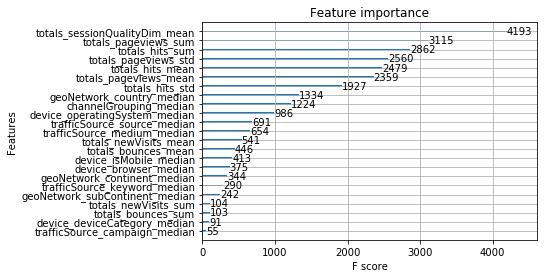

In [24]:
# Plot feature importance
xgboost.plot_importance(xgbr)
plt.rcParams['figure.figsize'] = [9, 6]
plt.show()

<h3>4. Predict and Create Submission Dataset</h3>

In [26]:
dfSubmit = dfTest_agg[['fullVisitorId']].copy()
dfSubmit['PredictedLogRevenue'] = xgbr.predict(X_test)
dfSubmit.loc[dfSubmit['PredictedLogRevenue'] < 0, 'PredictedLogRevenue'] = 0
dfSubmit.to_csv("xgb_submission_g.csv", index=False)

$\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$